In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import string

In [3]:
train_df = pd.read_csv('train_data (1).csv')
train_df.columns = ['review', 'label']

print(train_df.shape)
train_df.head()

(25000, 2)


,review,label
0,"This film is absolutely awful, but nevertheles...",0
1,Well since seeing part's 1 through 3 I can hon...,0
2,I got to see this film at a preview and was da...,1
3,This adaptation positively butchers a classic ...,0
4,Råzone is an awful movie! It is so simple. It ...,0


In [4]:
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rifat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # remove html tags
    text = text.lower()                                   # lowercase
    text = re.sub(r'\d+', ' ', text)                      # remove numbers
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()             # remove extra spaces
    tokens = [w for w in text.split() if w not in STOPWORDS]  # remove stopwords
    return " ".join(tokens)


In [6]:
train_df['clean_review'] = train_df['review'].apply(clean_text)
train_df.head()

,review,label,clean_review
0,"This film is absolutely awful, but nevertheles...",0,film absolutely awful nevertheless hilarious t...
1,Well since seeing part's 1 through 3 I can hon...,0,well since seeing part honestly say never made...
2,I got to see this film at a preview and was da...,1,got see film preview dazzled typical romantic ...
3,This adaptation positively butchers a classic ...,0,adaptation positively butchers classic beloved...
4,Råzone is an awful movie! It is so simple. It ...,0,råzone awful movie simple seems tried make mov...


In [7]:
df_clean = pd.DataFrame()
df_clean['clean_review'] = train_df['clean_review']
df_clean['label'] = train_df['label']

In [8]:
df_clean

,clean_review,label
0,film absolutely awful nevertheless hilarious t...,0
1,well since seeing part honestly say never made...,0
2,got see film preview dazzled typical romantic ...,1
3,adaptation positively butchers classic beloved...,0
4,råzone awful movie simple seems tried make mov...,0
...,...,...
24995,movie dirty harry movie clint eastwood stars p...,1
24996,screen adaptation john grisham story deserves ...,1
24997,film captured heart beginning hearing quincy j...,1
24998,deplorable social condition triggers catastrop...,1


In [9]:
df_clean.to_csv("df_clean.csv", index=False)


In [10]:
x = df_clean['clean_review']
y = df_clean['label']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 20000
Testing samples: 5000


In [12]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=200)

In [14]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8916

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2529
           1       0.87      0.92      0.89      2471

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Parameter grid for tuning
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5],
    'fit_prior': [True, False]
}

# Grid search
grid_nb = GridSearchCV(MultinomialNB(), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_nb.fit(X_train_tfidf, y_train)

# Best parameters
print("Best parameters:", grid_nb.best_params_)
best_nb_model = grid_nb.best_estimator_

# Predictions
y_pred_nb = best_nb_model.predict(X_test_tfidf)

# Evaluation
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'alpha': 1.5, 'fit_prior': True}
Naive Bayes Accuracy: 0.8604

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      2529
           1       0.85      0.87      0.86      2471

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



In [16]:
# Support Vector Machine (LinearSVC)
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
print("LinearSVC Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

LinearSVC Accuracy: 0.8796

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88      2529
           1       0.87      0.90      0.88      2471

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [18]:
# Hyperparameter optimization with GridSearchC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],    # regularization strength
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200, 500]
}

grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train_tfidf, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation accuracy: {grid.best_score_:.4f}")


best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)

print("Optimized model accuracy:", accuracy_score(y_test, y_pred_best))
print("\nOptimized model classification report:\n", classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'C': 1, 'max_iter': 200, 'solver': 'liblinear'}
Best cross-validation accuracy: 0.8764
Optimized model accuracy: 0.891

Optimized model classification report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2529
           1       0.87      0.92      0.89      2471

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



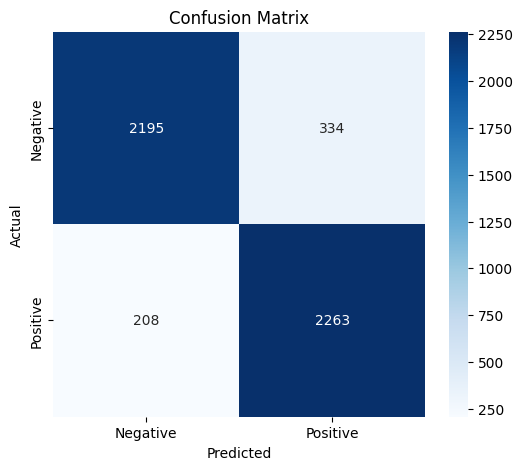

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import joblib

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Deep Learning Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Convert TF-IDF matrices to arrays
X_train_dl = X_train_tfidf.toarray()
X_test_dl = X_test_tfidf.toarray()

# Build the model
model_dl = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dl.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_dl.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model_dl.fit(
    X_train_dl, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Predict class labels for test set
y_pred_dl_prob = model_dl.predict(X_test_dl)
y_pred_dl = (y_pred_dl_prob > 0.5).astype(int).flatten()  # Convert probabilities to 0/1

# Evaluate
loss, accuracy = model_dl.evaluate(X_test_dl, y_test)
print(f"\nDeep Learning model accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_dl, target_names=['Negative', 'Positive']))


Epoch 1/20
250/250 [==============================] - 2s 6ms/step - loss: 0.4044 - accuracy: 0.8171 - val_loss: 0.2913 - val_accuracy: 0.8823
Epoch 2/20
250/250 [==============================] - 1s 4ms/step - loss: 0.2192 - accuracy: 0.9176 - val_loss: 0.2934 - val_accuracy: 0.8783
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 0.1519 - accuracy: 0.9456 - val_loss: 0.3192 - val_accuracy: 0.8752
Epoch 4/20
157/157 [==============================] - 0s 3ms/step - loss: 0.2837 - accuracy: 0.8788

Deep Learning model accuracy: 0.8788

Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.91      0.88      2529
    Positive       0.90      0.85      0.87      2471

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [40]:
import joblib

joblib.dump(model, 'logistic_regression_imdb_optimized.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [39]:
# Load saved model and vectorizer
model = joblib.load('logistic_regression_imdb_optimized.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [38]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = " ".join(text.split())
    return text


In [37]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vect_text = vectorizer.transform([cleaned])
    pred = model.predict(vect_text)[0]
    return "Positive" if pred == 1 else "Negative"

In [36]:
# Example sentence
sentence = "I really enjoyed this movie! The plot was exciting and the acting was superb."

# Predict sentiment
sentiment = predict_sentiment(sentence)
print("Predicted Sentiment:", sentiment)

Predicted Sentiment: Positive


In [35]:
# Example sentence
sentence = "The movie was bad."

# Predict sentiment
sentiment = predict_sentiment(sentence)
print("Predicted Sentiment:", sentiment)

Predicted Sentiment: Negative
